In [1]:
import torch
import numpy as np
import torch.nn as nn
import networkx as nx
import pandas as pd
import scipy.linalg as LIN
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.weight'] = 'medium'

%matplotlib inline

In [2]:
class Threat_Model(nn.Module):
    def __init__(self, S, S_prime, Alpha, budget, G):
        super(Threat_Model, self).__init__()
        self.S = S
        self.S_prime = S_prime
        self.x_s = torch.zeros(size)    # characteristic vector of S
        self.x_s[S] = 1
        self.alpha_1, self.alpha_2, self.alpha_3 = Alpha
        self.budget = budget
        self.used_budget = 0 
        self.lambda1_S_prime = 0
        self.lambda1_S = 0
        self.normalizedCut = 0
        self.lambda1 = 0
        
        adj = nx.adjacency_matrix(G).todense()
        self.mask = torch.tensor(adj, dtype=torch.float32)
        eigVals, eigVecs = torch.symeig(self.mask, eigenvectors=True)
        # eig-vector associated with the largest eig-value of A (since mask = A)
        self.eig_v = eigVecs[:, -1]
        self.original_lambda1 = eigVals[-1]
        
        self.adj_tensor = torch.tensor(adj, dtype=torch.float32).requires_grad_(True)
        self.adj_tensor = nn.Parameter(self.adj_tensor)
        # masking the gradients backpropagated to adj_tensor
        self.adj_tensor.register_hook(lambda x: x * self.mask)
        
    def forward(self):
        '''Compute the loss function given current adjacency matrix.'''
        # Degree and Laplacian matrices
        size = self.adj_tensor.size()[0]
        D = torch.diag(torch.mm(self.adj_tensor, torch.ones(size).view(-1, 1)).squeeze())
        L = D - self.adj_tensor
    
        # select the sub-matrix corresponding to S
        adj_tensor_S = torch.index_select(torch.index_select(
            self.adj_tensor, 0, self.S), 1, self.S)
        adj_tensor_S_prime = torch.index_select(torch.index_select(
            self.adj_tensor, 0, self.S_prime), 1, self.S_prime)
    
        # all sorts of largest eigenvalues 
        self.lambda1 = torch.max(torch.symeig(self.adj_tensor, eigenvectors=True)[0])
        self.lambda1_S = torch.max(torch.symeig(adj_tensor_S, eigenvectors=True)[0])
        self.lambda1_S_prime = torch.max(torch.symeig(adj_tensor_S_prime, eigenvectors=True)[0])
        
        # centrality measure
        # Before:
        #self.normalizedCut = (torch.mm(self.x_s.view(1, -1), torch.mm(L, self.x_s.view(-1, 1))) /
        #                      (0.5 * adj_tensor_S.sum()))
        # Now:
        self.normalizedCut = (torch.mm(self.x_s.view(1, -1), torch.mm(L, self.x_s.view(-1, 1))) / 
                              torch.mm(self.x_s.view(1, -1), torch.mm(D, self.x_s.view(-1, 1))))
        
        # the loss is minus the objective function
        Loss = -1 * (self.alpha_1 * self.lambda1_S -
                     self.alpha_2 * self.lambda1_S_prime +
                     self.alpha_3 * self.normalizedCut)
        return Loss
    
    
    # check if the attacker still has budget
    def update_used_budget(self):
        # make sure the attacker has made some attack
        if self.adj_tensor.grad != None:
            current_used_budget = torch.abs(
                torch.mm(self.eig_v.view(1, -1), torch.mm(self.aggre_change, self.eig_v.view(-1, 1))))
            self.used_budget += current_used_budget 
    
    # return the results that we are interested in
    def getRet(self):
        return self.lambda1_S, self.lambda1, self.normalizedCut
    
    
    def get_used_budget(self):
        return torch.Tensor(self.used_budget).clone()

In [5]:
# Create graph to run attack on
size = 1000
G = nx.watts_strogatz_graph(size, 10, 0.2)
# G = nx.barabasi_albert_graph(size, 4)
adj = nx.to_numpy_array(G)

# The target subgraph is a random node plus all its neighbors
center = np.random.choice(G)
S = list(G.neighbors(center)) + [center]
S_prime = list(set(G.nodes()) - set(S))
S = torch.LongTensor(S)
S_prime = torch.LongTensor(S_prime)

# Set parameters for objective function and optimization
alpha1, alpha2, alpha3 = 0.05, 0.05, 0.9
learning_rate = 1e-1
Attacker = Threat_Model(S, S_prime, [alpha1, alpha2, alpha3], 0.1, G)
opt = torch.optim.Adam(Attacker.parameters(), lr=learning_rate)

# Run gradient descent
ret = {'lambda_1': [], 'lambda_1_S': [], 'centrality': []}
num_iter = 100
Losses = []
for i in range(num_iter):
    if i % 10 == 0:
        print(i)
    Loss = Attacker()
    Losses.append(Loss.item())
    lambda1_S, lambda1, normalizedCut = Attacker.getRet()
    ret['lambda_1'].append(lambda1.item())
    ret['lambda_1_S'].append(lambda1_S.item())
    ret['centrality'].append(normalizedCut.item())
    opt.zero_grad()
    Loss.backward()
    opt.step()
            
ret = pd.DataFrame(ret) 

0
10
20
30
40
50
60
70
80
90


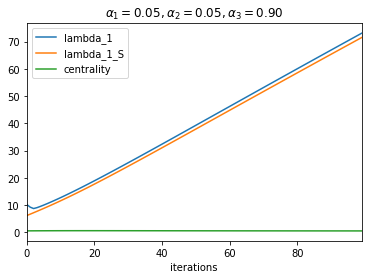

In [6]:
ret.plot(kind='line')
plt.xlabel('iterations')
plt.title(r'$\alpha_1={:.2f}, \alpha_2={:.2f}, \alpha_3={:.2f}$'.format(alpha1, alpha2, alpha3));